In [1]:
data1 <- read.csv(file="ULM.csv", header=TRUE, sep=",")
data2 <- read.table(file="AMLSG_Classification.txt", header = TRUE, sep = "")
data3 <- read.table(file="AMLSG_FLT3ITD.txt", header = TRUE, sep = "")
data4 <- read.table(file="AMLSG_Karyotypes.txt", header = TRUE, sep = "")
data5 <- read.table(file="AMLSG_Genetic.txt", header = TRUE, sep = "")
colnames(data4)[colnames(data4)=="PDID"] <- "ID"
colnames(data5)[colnames(data5)=="SAMPLE_NAME"] <- "ID"

In [3]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)

source('../../../../src/tools.R')     # custom tools function
source('../../../../src/hdp_tools_yanis.R')
source("../../../../src/merge_df.R")
source("../../../../src/my_toolbox.R")
source("../../../../src/my_components.R")
source("../../../../src/my_utils.R")
source("../../../../src/ggstyles.R")
source("../../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed
library(dummies)
library(dplyr)
library(stringr)
data5<- cbind(data5,dummy('GENE',data5, sep = "_"))

data5 <- data5[,c(3,23:76)]
data5 <- data5[!duplicated(data5), ]


data5 <- data5 %>% 
  group_by(ID) %>% 
  summarise_all(list(sum))

colnames(data5)[colnames(data5)=="GENE_SFRS2"] <- "GENE_SRSF2"   ###ERROR IN THE COLNAME
names(data5) <- gsub("GENE_", "", names(data5), fixed = TRUE)

# data4 %>%
#   filter(str_detect(karyotype, "t\\(11"))

ERROR: Can't find column `GENE` in `.data`.

In [4]:
tmp <- merge(data1,data2, by="ID")
dim(tmp)
tmp <- merge(tmp,data3,by ="ID")
dim(tmp)
# tmp <- merge(tmp,data4,by ="ID")
tmp <- left_join(tmp,data4,by="ID")

tmp <- merge(tmp,data5[,c('ID','DNMT3A','IDH1','IDH2','WT1','TP53','ZRSR2',
                 'U2AF1','SRSF2','SF3B1','ASXL1','STAG2','BCOR','RUNX1',
                 'EZH2','MLL','PHF6','SF1','NF1','CUX1')],by="ID")  # to not conflict between genes . from data2 and data5


cols_to_keep <- c('ID','Gender','Age','BM_Blasts','HB','PLT','WBC','OS','OS_Status','NPM1','CEBPA_bi',
                  'inv16','t15_17','t8_21','t6_9','inv3','t_MLL','chromatin_spliceosome','p53_aneuploidy',
                  'IDH2_p172','Ambiguous_classification','No_drivers','No_class','Overall_classification',
                  'FLT3_ITD_status','karyotype','DNMT3A','IDH1','IDH2','WT1','TP53','ZRSR2',
                 'U2AF1','SRSF2','SF3B1','ASXL1','STAG2','BCOR','RUNX1',
                 'EZH2','MLL','PHF6','SF1','NF1','CUX1')
tmp <- tmp[,cols_to_keep]
dim(tmp)
# Add t 11 from karyotype
tmp$t11 <- ifelse(grepl("t\\(11|;11",tmp$karyotype),1,0)
# tmp$additions <- ifelse(grepl("add\\(8|\\+8|add\\(13|\\+13|add\\(21|\\+21|add\\(22|\\+22",tmp$karyotype),1,0)
tmp$additions <- ifelse(grepl("add\\(8|add\\(13|add\\(21|add\\(22",tmp$karyotype),1,0)
tmp$complex <- ifelse(str_count(tmp$karyotype,"add|del|\\+|\\-")>=3,1,0)  ## to change
tmp$ITD <- ifelse(tmp$FLT3_ITD_status=="ITD",1,0)

[1] 1540   40

[1] 1540   51

[1] 1379   45

In [6]:
factors <- c("ZRSR2","U2AF1","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1")
mol_defining <- c('NPM1','CEBPA_bi','inv16','t15_17','t8_21','t6_9','inv3','DNMT3A','IDH1','IDH2','WT1',factors)
correlates <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt","gender","age","os","os_status")
tmp$full_component_t_15_17 <- ifelse((tmp$t15_17==1),1,0) 

tmp$full_component_inv_16 <- ifelse((tmp$inv16==1),1,0) 

tmp$full_component_t_8_21 <- ifelse((tmp$t8_21==1 & tmp$ITD==0),1,0) 
tmp$full_component_t_8_21_ITD <- ifelse((tmp$t8_21==1 & tmp$ITD==1),1,0) 

tmp$full_component_t_11 <- ifelse((tmp$t11==1),1,0)  

tmp$full_component_t_6_9 <- ifelse((tmp$t6_9==1 & tmp$ITD==0),1,0) 
tmp$full_component_t_6_9_ITD <- ifelse((tmp$t6_9==1 & tmp$ITD==1),1,0)

tmp$full_component_inv_3 <- ifelse((tmp$inv3==1),1,0)

tmp$full_component_additions <- ifelse((tmp$additions==1),1,0)

# tmp$full_component_TP53_complex <- ifelse((tmp$TP53==1 | tmp$complex==1) ,1,0)
tmp$full_component_TP53_complex <- ifelse((tmp$p53_aneuploidy==1) ,1,0)

tmp$full_component_NPM1 <- ifelse((tmp$NPM1==1 & tmp$ITD==0),1,0) 
tmp$full_component_NPM1_ITD <- ifelse((tmp$NPM1==1 & tmp$ITD==1),1,0)

tmp$full_component_CEBPA_bi <- ifelse((tmp$CEBPA_bi==1 & tmp$ITD==0),1,0) 
tmp$full_component_CEBPA_bi_ITD <- ifelse((tmp$CEBPA_bi==1 & tmp$ITD==1),1,0)

tmp$full_component_DNMT3A_IDH1_2 <- ifelse((tmp$DNMT3A==1 & (tmp$IDH1==1 | tmp$IDH2==1 ) & tmp$ITD==0),1,0)
tmp$full_component_DNMT3A_IDH1_2_ITD <- ifelse((tmp$DNMT3A==1 & (tmp$IDH1==1 | tmp$IDH2==1 & tmp$ITD==1)),1,0)

tmp$full_component_WT1 <- ifelse((tmp$WT1==1 & tmp$ITD==0),1,0) 
tmp$full_component_WT1_ITD <- ifelse((tmp$WT1==1 & tmp$ITD==1),1,0) 

# tmp$full_component_chr_splicing_multiple <- ifelse((rowSums(tmp[,factors])>1) ,1,0)
tmp$full_component_chr_splicing_multiple <- ifelse((tmp$chromatin_spliceosome==1) ,1,0)

tmp$full_component_chr_splicing_1 <- ifelse((rowSums(tmp[,factors])==1),1,0)

tmp$full_component_not_assigned <- ifelse((rowSums(tmp[,mol_defining])==0 & tmp$ITD==0),1,0)
tmp$full_component_not_assigne_ITD <- ifelse((rowSums(tmp[,mol_defining])==0 & tmp$ITD==1),1,0)

# tmp$full_component_no_events <- ifelse(df_final$final_component=="no_events",1,0)

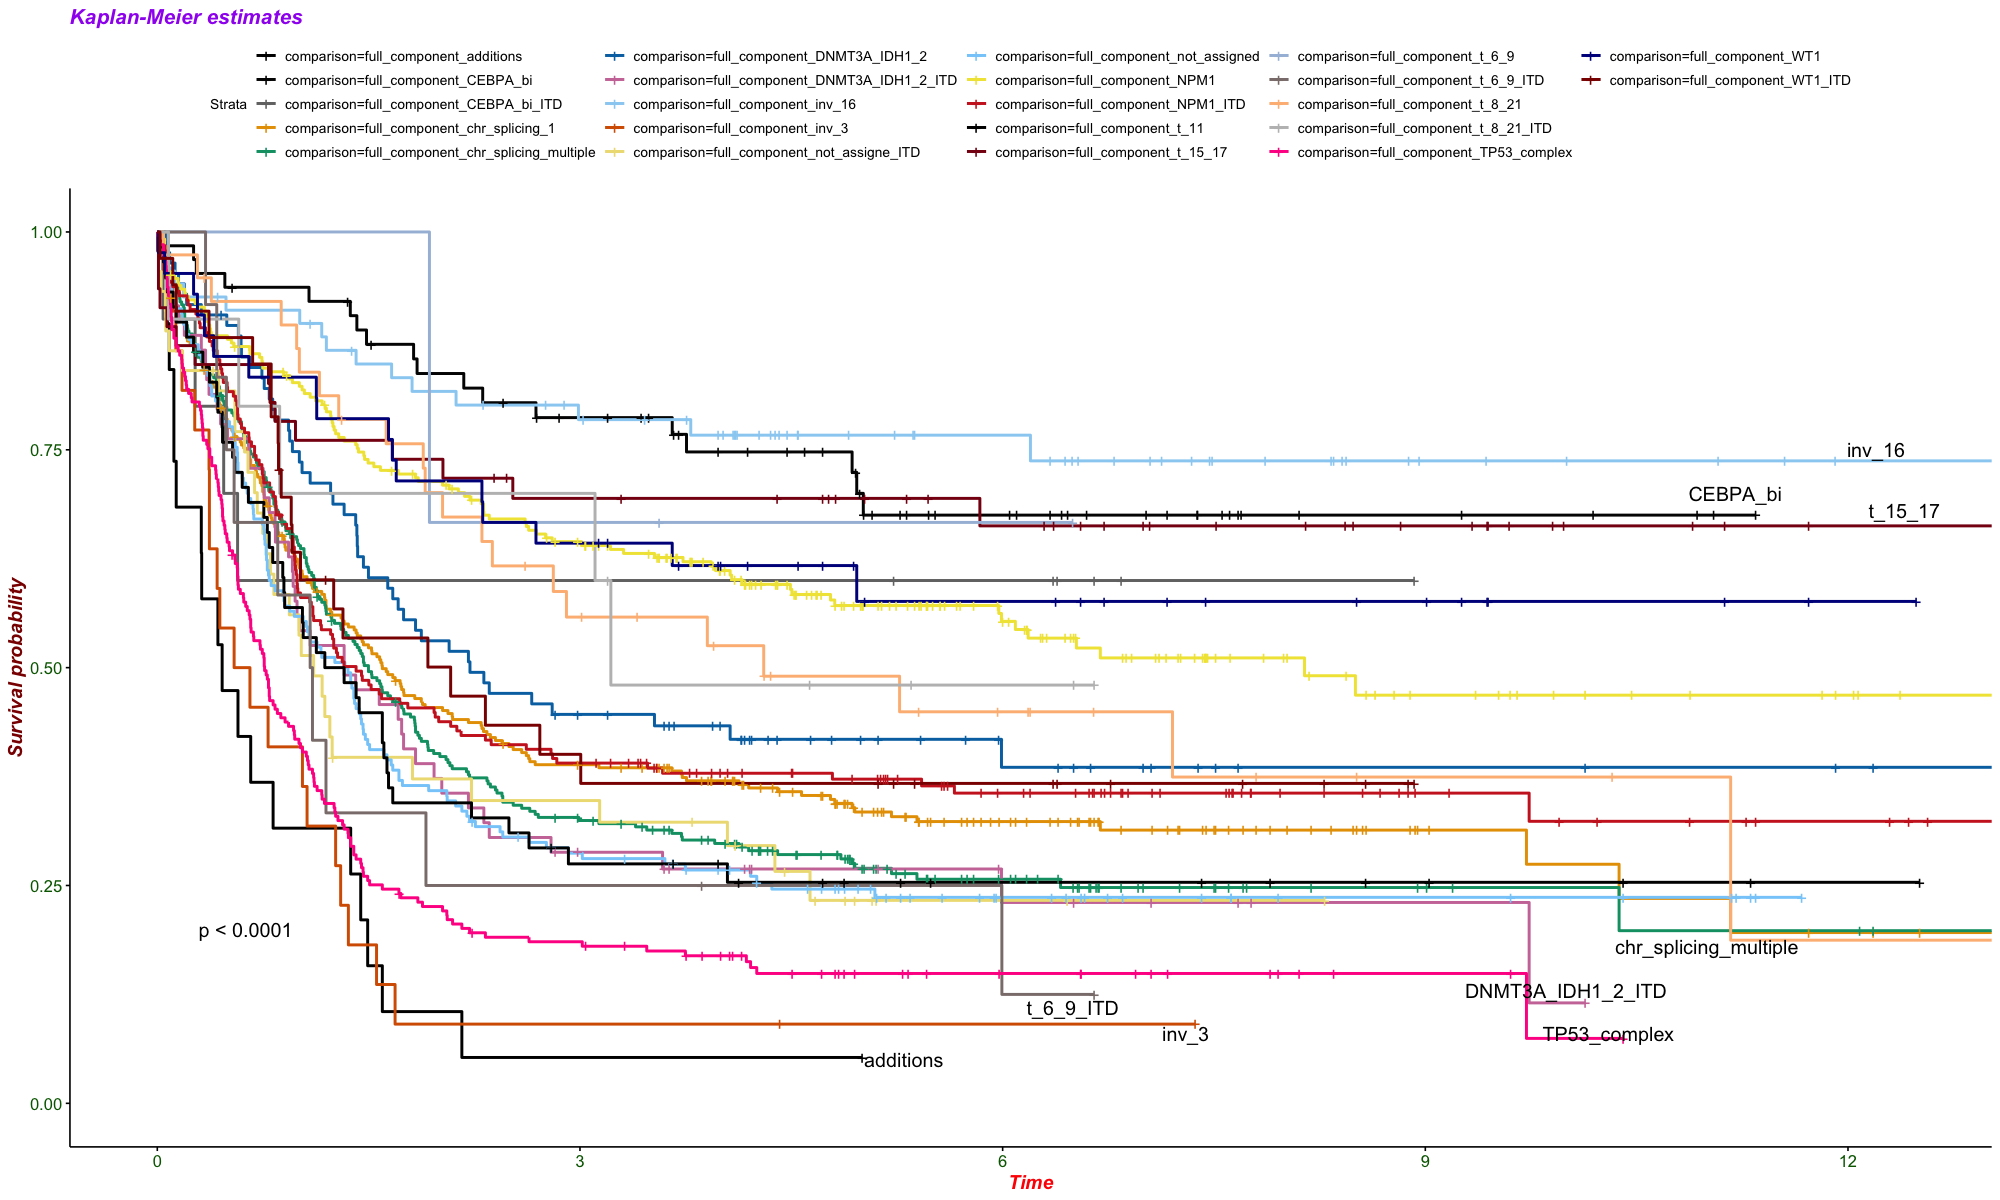

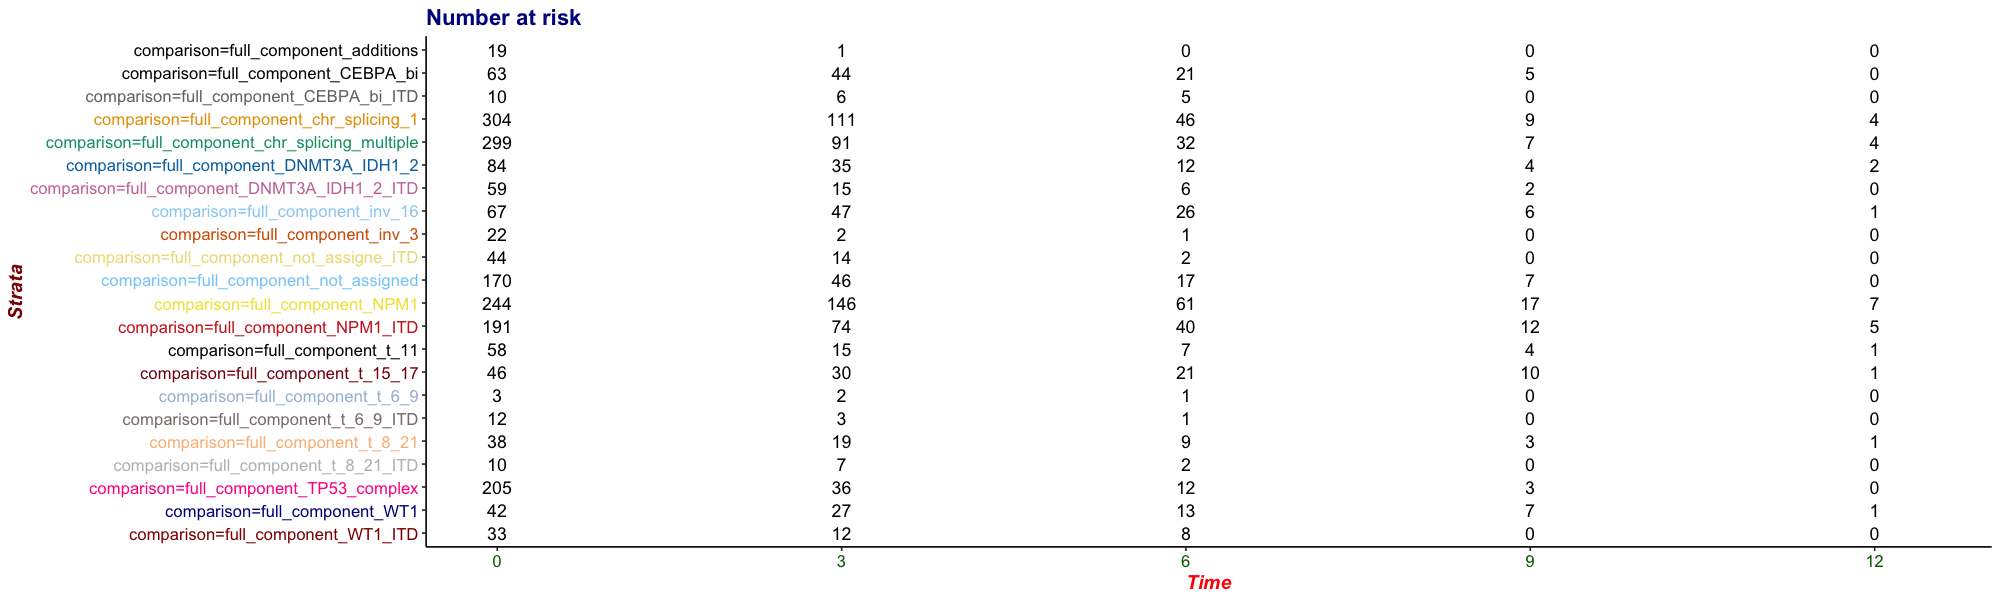

In [8]:
df_w_correlates <- tmp
df_final <- tmp
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
tmp1 <- NULL
# for (comp in cols_component[c(1,3,2,13,18,19,10,16,8,6,7,9)]){
for (comp in cols_component){
    tmp2 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp2$comparison <- comp
    tmp1 <- rbind(tmp1,tmp2)
    }

# tmp1 <- df_w_correlates
# tmp1$comparison <- ifelse(tmp1$eln_2017==1,"adverse",
#                           ifelse(tmp1$eln_2017==2,"intermediate","favorable"))
                          
# tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp1$OS, event = tmp1$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp1)
p <- ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates",xlim=c(0,12.4),break.time.by=3,palette=colors,#linetype=c(1,1,rep(3,16),1),
                  ggtheme = theme_survminer(
                 font.main = c(16, "bold", "darkblue"),
                 font.submain = c(15, "bold.italic", "purple"),
                 font.caption = c(14, "plain", "orange"),
                 font.x = c(14, "bold.italic", "red"),
                 font.y = c(14, "bold.italic", "darkred"),
                 font.tickslab = c(12, "plain", "darkgreen")))

set_notebook_plot_size(20,12)
p$plot + ggplot2::annotate("text", 
                                x = c(5.3,7.3,10.3,10,11,6.5,12.2,11.2,12.4), y = c(0.05,0.08,0.08,0.13,0.18,0.11,0.75,0.7,0.68),
                                label = c("additions","inv_3","TP53_complex","DNMT3A_IDH1_2_ITD","chr_splicing_multiple","t_6_9_ITD","inv_16","CEBPA_bi","t_15_17"), size = 5)
set_notebook_plot_size(20,6)
p$table

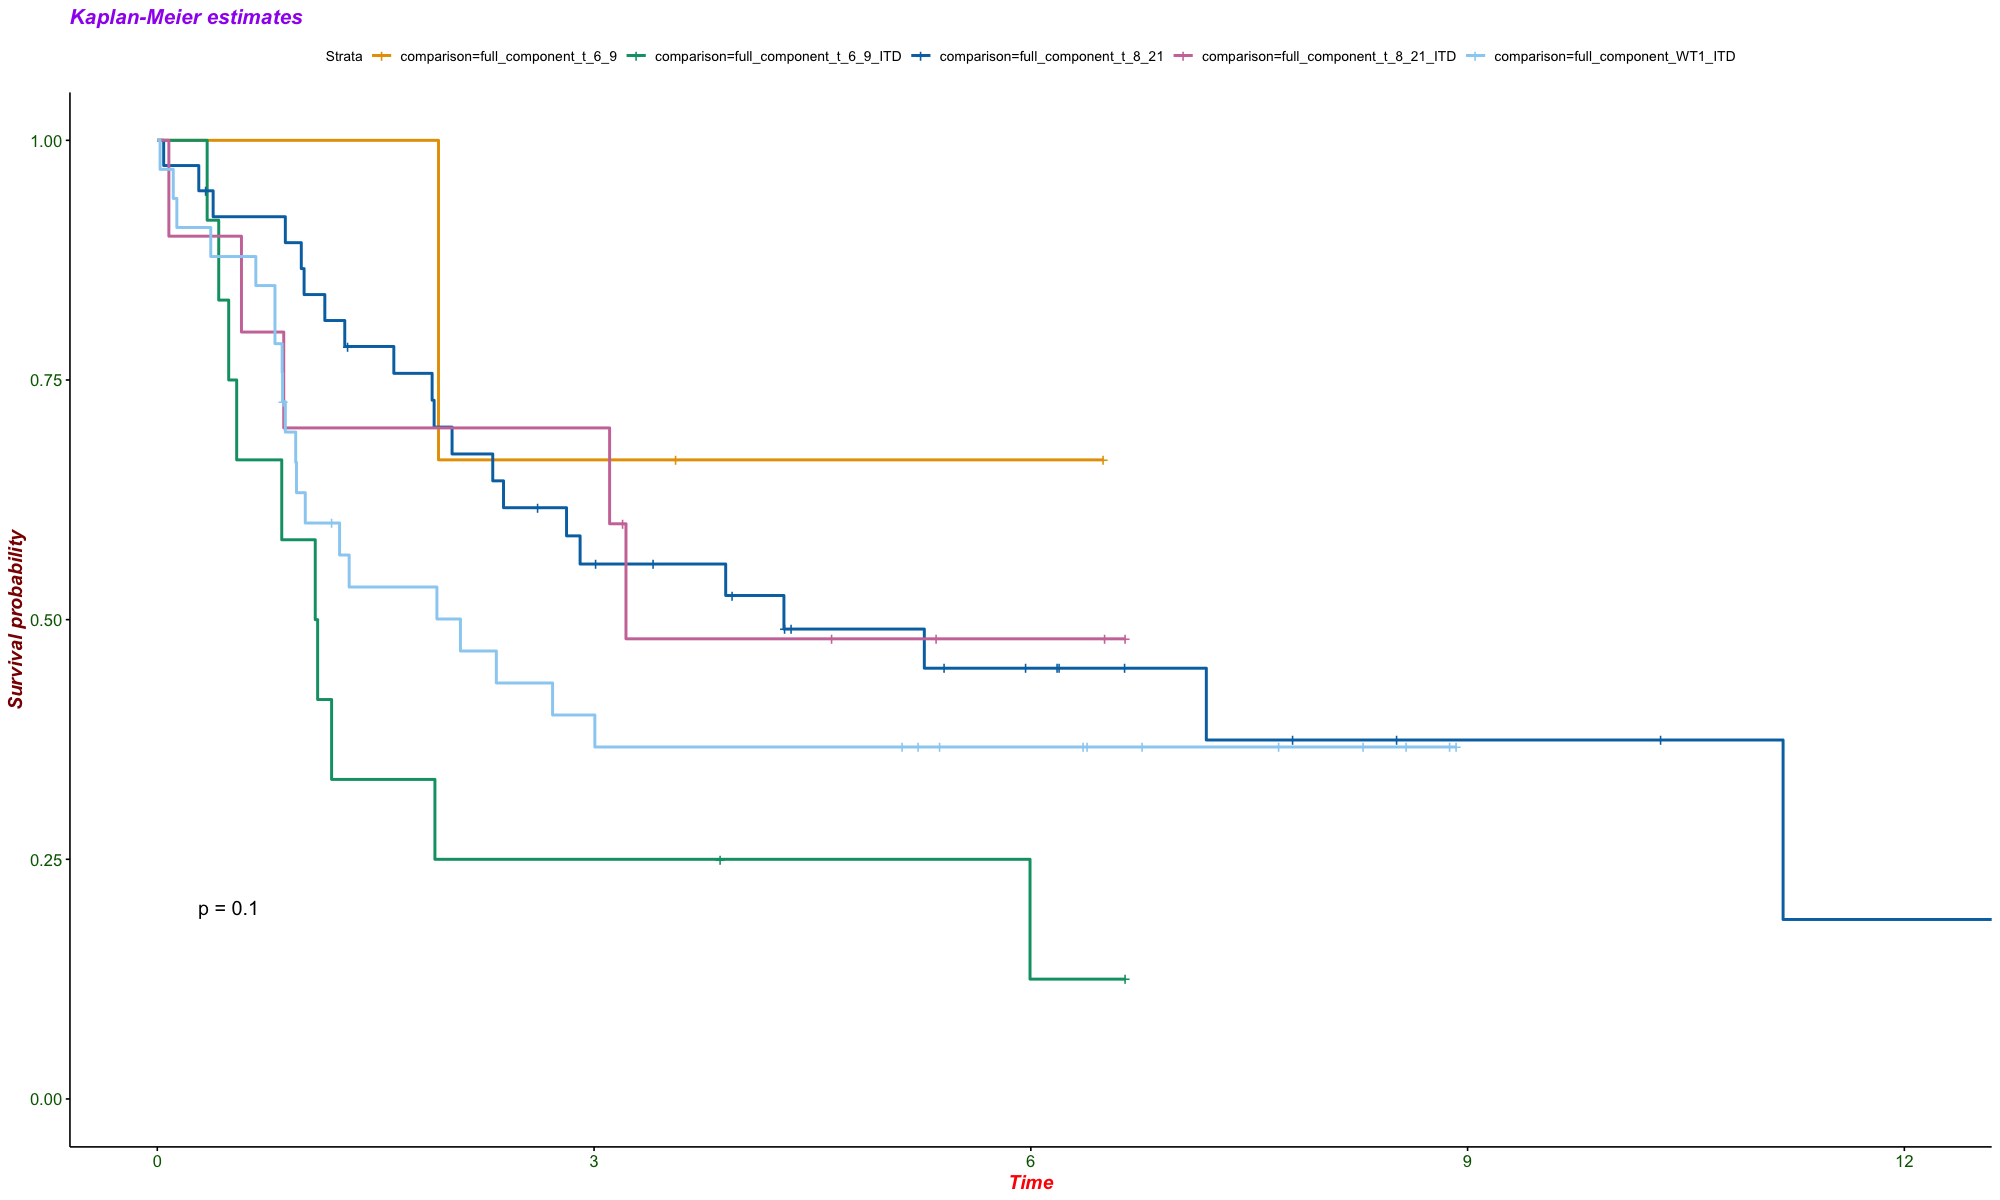

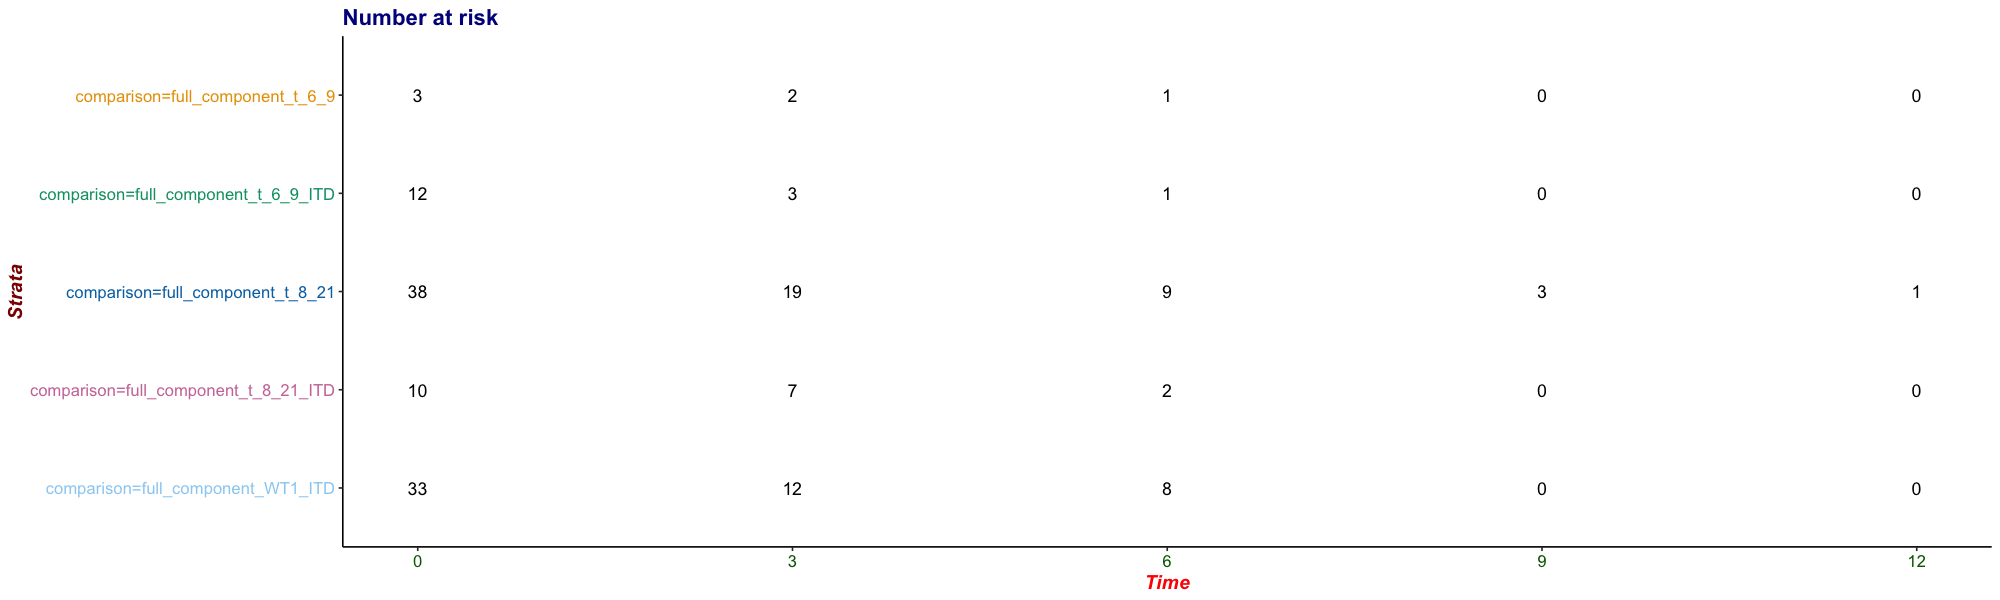

In [569]:
df_w_correlates <- tmp
df_final <- tmp
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
colors <- c( "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
tmp1 <- NULL
# for (comp in cols_component[c(1,3,2,13,18,19,10,16,8,6,7,9)]){
for (comp in cols_component[c(3,6,7,4,18)]){
    tmp2 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp2$comparison <- comp
    tmp1 <- rbind(tmp1,tmp2)
    }

# tmp1 <- df_w_correlates
# tmp1$comparison <- ifelse(tmp1$eln_2017==1,"adverse",
#                           ifelse(tmp1$eln_2017==2,"intermediate","favorable"))
                          
# tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp1$OS, event = tmp1$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp1)
p <- ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates",xlim=c(0,12),break.time.by=3,palette=colors,#linetype=c(1,1,rep(3,16),1),
                  ggtheme = theme_survminer(
                 font.main = c(16, "bold", "darkblue"),
                 font.submain = c(15, "bold.italic", "purple"),
                 font.caption = c(14, "plain", "orange"),
                 font.x = c(14, "bold.italic", "red"),
                 font.y = c(14, "bold.italic", "darkred"),
                 font.tickslab = c(12, "plain", "darkgreen")))

set_notebook_plot_size(20,12)
p$plot #+ ggplot2::annotate("text", 
                                #x = c(4.7,5.7,7.7,9,8,11,11.5,12,7.2,5.8,9,7.7), y = c(0.05,0,0.08,0,0.1,0.13,0.15,0.47,0.52,0.72,0.69,0.78),
                                #label = c("inv_3","t_6_9","TP53_complex","additions","chr_splicing_multiple","Adverse ELN","Intermediate ELN","Favorable ELN","CEBPA_bi","inv_16","t_8_21","t_15_17"), size = 5)
set_notebook_plot_size(20,6)
p$table

In [577]:
data_aml <- read.table("../../../clustering/clustering_Final_1/df_final_full_component_ITD.tsv")

In [578]:
head(data_aml)
genes <- data_aml[,c(5:88)]
cyto <- data_aml[,c(89:158)]

# eln_features_missing <- t(16,16),t(3,3),minus5, del_5q, minus7, minus17

,eln_2017,eln_2017_adverse,eln_2017_favorable,eln_2017_intermediate,ASXL1,ASXL2,ASXL3,ATRX,BAGE3,BCOR,BRAF,CBFB,CBL,CDKN2A,CEBPA_bi,CEBPA_mono,CNTN5,CREBBP,CSF1R,CSF3R,CTCF,CUL2,CUX1,DNMT3A,EED,ETV6,EZH2,FBXW7,ITD,FLT3_TKD,FLT3_other,GATA1,GATA2,GNAS,GNB1,IDH1,IDH2_p.R140,IDH2_p.R172,JAK2,JAK3,KANSL1,KDM6A,KIT,KMT2C,KMT2D,KMT2E,KRAS,LUC7L2,MED12,MLL,MPL,MYC,NF1,NFE2,NOTCH1,NPM1,NRAS_other,NRAS_p.G12_13,NRAS_p.Q61_62,PDS5B,PHF6,PPFIA2,PRPF8,PTEN,PTPN11,PTPRF,PTPRT,RAD21,RIT1,RUNX1,S100B,SETBP1,SF1,SF3B1,SMC1A,SMC3,SMG1,SPP1,SRSF2,STAG2,STAT5B,SUZ12,TET2,TP53,U2AF1_p.S34,U2AF1_p.Q157,WT1,ZRSR2,add_8,add_11,add_13,add_21,add_22,del_20,del_3,del_5,del_7,del_9,del_12,del_13,del_16,del_17,del_18,minusy,t_v_11,t_10_21,t_12_13,t_12_17,t_12_22,t_13_19,t_15_16,t_15_17,t_16_17,t_16_21,t_17_19,t_17_21,t_1_12,t_1_14,t_1_16,t_1_17,t_1_19,t_1_3,t_1_4,t_1_5,t_1_6,t_2_17,t_2_3,t_2_5,t_2_7,t_2_9,t_3_16,t_3_21,t_3_5,t_3_7,t_3_9,t_4_12,t_4_21,t_4_9,t_5_12,t_5_17,t_5_9,t_6_9,t_7_16,t_7_17,t_7_8,t_8_10,t_8_13,t_8_16,t_8_17,t_8_21,t_9_11,t_9_13,t_9_17,t_9_22,complex,others_transloc,inv_3,inv_16,ahd,perf_status,bm_blasts,secondary,wbc,hb,plt,gender,age,final_component,final_component_numeric,full_component_t_15_17,full_component_inv_16,full_component_t_8_21,full_component_t_8_21_ITD,full_component_t_11,full_component_t_6_9,full_component_t_6_9_ITD,full_component_inv_3,full_component_additions,full_component_TP53_complex,full_component_NPM1,full_component_NPM1_ITD,full_component_CEBPA_bi,full_component_CEBPA_bi_ITD,full_component_DNMT3A_IDH1_2,full_component_DNMT3A_IDH1_2_ITD,full_component_WT1,full_component_WT1_ITD,full_component_chr_splicing_multiple,full_component_chr_splicing_1,full_component_not_assigned,full_component_not_assigned_ITD,full_component_no_events,overlap,os,os_status
PD14868a,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,89,1,175.0,9.899994,199,0,79.71253,NPM1,9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.19164956,1
PD14869c,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,90,1,3.1,8.699997,23,1,65.04312,t_11,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.70636550,0
PD14871a,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,62,1,127.0,7.599998,57,1,79.65777,NPM1,9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.37782341,1
PD14872a,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,40,1,8.2,7.699997,124,0,66.50513,TP53_complex,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04928131,1
PD14873a,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25,2,44.2,9.299995,40,1,71.78097,chr_splicing_multiple,13,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.55030801,1
PD14874a,1,1,0,0,0,0,0,0,0,0,

In [595]:
load.Rdata("AMLSG_Clinical_Anon.RData",'dat.rd')

In [600]:
colnames(data_aml)

[1] "eln_2017"                            
  [2] "eln_2017_adverse"                    
  [3] "eln_2017_favorable"                  
  [4] "eln_2017_intermediate"               
  [5] "ASXL1"                               
  [6] "ASXL2"                               
  [7] "ASXL3"                               
  [8] "ATRX"                                
  [9] "BAGE3"                               
 [10] "BCOR"                                
 [11] "BRAF"                                
 [12] "CBFB"                                
 [13] "CBL"                                 
 [14] "CDKN2A"                              
 [15] "CEBPA_bi"                            
 [16] "CEBPA_mono"                          
 [17] "CNTN5"                               
 [18] "CREBBP"                              
 [19] "CSF1R"                               
 [20] "CSF3R"                               
 [21] "CTCF"                                
 [22] "CUL2"                                
 [23] "CUX1"                                
 [24] "DNMT3A"                              
 [25] "EED"                                 
 [26] "ETV6"                                
 [27] "EZH2"                                
 [28] "FBXW7"                               
 [29] "ITD"                                 
 [30] "FLT3_TKD"                            
 [31] "FLT3_other"                          
 [32] "GATA1"                               
 [33] "GATA2"                               
 [34] "GNAS"                                
 [35] "GNB1"                                
 [36] "IDH1"                                
 [37] "IDH2_p.R140"                         
 [38] "IDH2_p.R172"                         
 [39] "JAK2"                                
 [40] "JAK3"                                
 [41] "KANSL1"                              
 [42] "KDM6A"                               
 [43] "KIT"                                 
 [44] "KMT2C"                               
 [45] "KMT2D"                               
 [46] "KMT2E"                               
 [47] "KRAS"                                
 [48] "LUC7L2"                              
 [49] "MED12"                               
 [50] "MLL"                                 
 [51] "MPL"                                 
 [52] "MYC"                                 
 [53] "NF1"                                 
 [54] "NFE2"                                
 [55] "NOTCH1"                              
 [56] "NPM1"                                
 [57] "NRAS_other"                          
 [58] "NRAS_p.G12_13"                       
 [59] "NRAS_p.Q61_62"                       
 [60] "PDS5B"                               
 [61] "PHF6"                                
 [62] "PPFIA2"                              
 [63] "PRPF8"                               
 [64] "PTEN"                                
 [65] "PTPN11"                              
 [66] "PTPRF"                               
 [67] "PTPRT"                               
 [68] "RAD21"                               
 [69] "RIT1"                                
 [70] "RUNX1"                               
 [71] "S100B"                               
 [72] "SETBP1"                              
 [73] "SF1"                                 
 [74] "SF3B1"                               
 [75] "SMC1A"                               
 [76] "SMC3"                                
 [77] "SMG1"                                
 [78] "SPP1"                                
 [79] "SRSF2"                               
 [80] "STAG2"                               
 [81] "STAT5B"                              
 [82] "SUZ12"                               
 [83] "TET2"                                
 [84] "TP53"                                
 [85] "U2AF1_p.S34"                         
 [86] "U2AF1_p.Q157"                        
 [87] "WT1"                                 
 [88] "ZRSR2"                               
 [89] "add_8"                             

In [601]:
mean(data_aml[data_aml$full_component_t_11==1,]$os)

[1] 2.147727